The purpose of this notebook is to try to predict percentiles for spectra generated from SFHs not necessarily exponential, but with a model trained only with spectra from tau-delayed exponential SFHs. The idea is: even if the functional form of the SFH is different, the percentiles minimize that differences, so our model might be able to predict proper percentiles.

We load the modules we need

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference


import sys
from scipy import  integrate
from scipy import interpolate
import os
from astropy.io import fits

We define new parametrizations

0.1 0.0


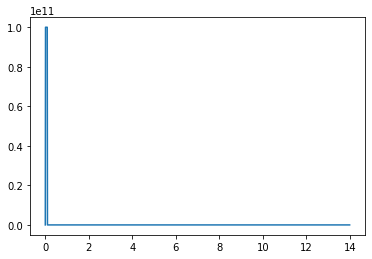

0.1 1.4444444444444444


/var/folders/26/90klcxjd1_x9q0l8mz3tx1g00000gn/T/ipykernel_49753/3538718787.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i=integrate.quad(lambda t: 1*escalon_delta(t,ti,deltat),0,14)


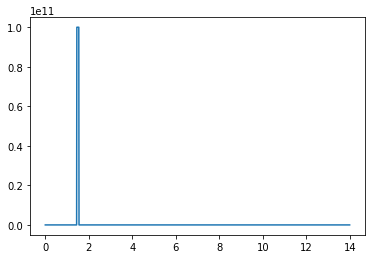

0.1 2.888888888888889


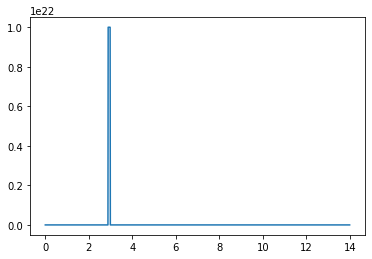

0.1 4.333333333333333


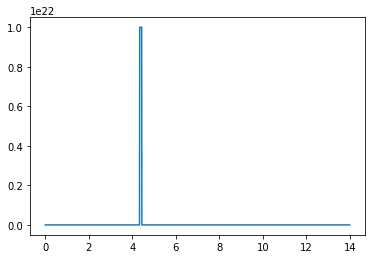

0.1 5.777777777777778


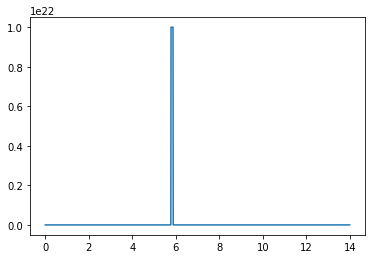

0.1 7.222222222222222


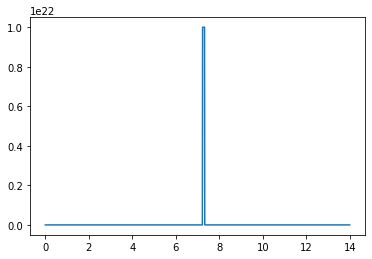

0.1 8.666666666666666


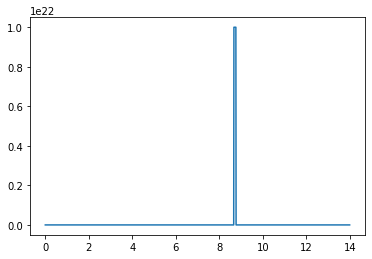

0.1 10.11111111111111


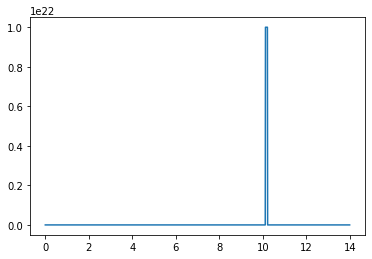

0.1 11.555555555555555


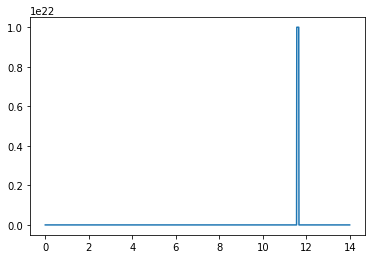

0.1 13.0


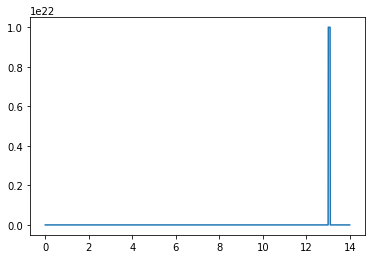

0.6444444444444445 0.0


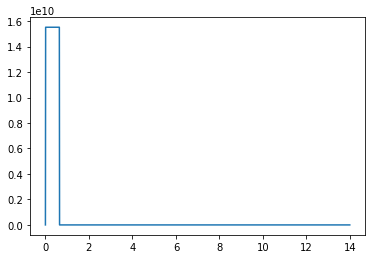

0.6444444444444445 1.4444444444444444


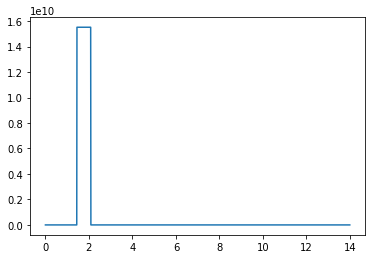

0.6444444444444445 2.888888888888889


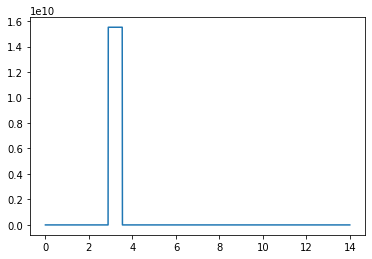

0.6444444444444445 4.333333333333333


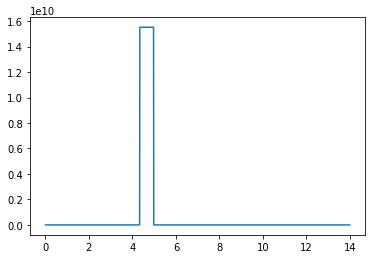

0.6444444444444445 5.777777777777778


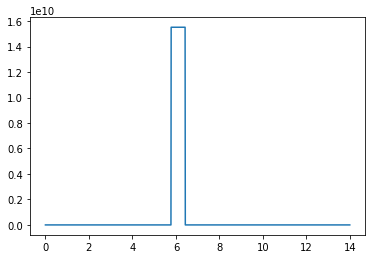

0.6444444444444445 7.222222222222222


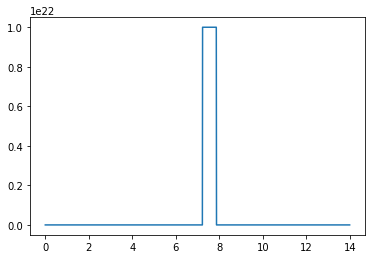

0.6444444444444445 8.666666666666666


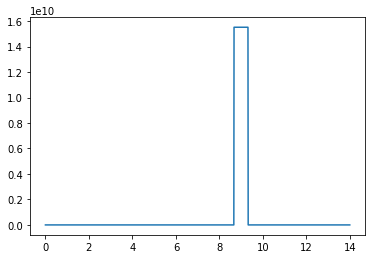

0.6444444444444445 10.11111111111111


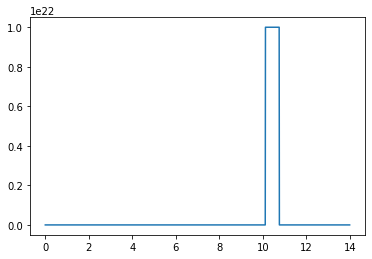

0.6444444444444445 11.555555555555555


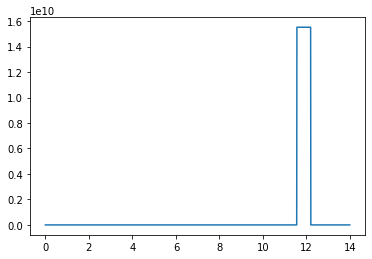

0.6444444444444445 13.0


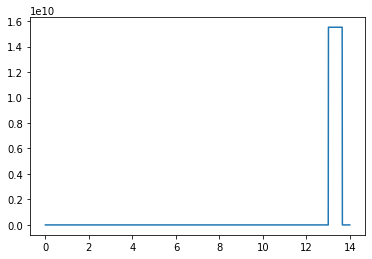

1.188888888888889 0.0


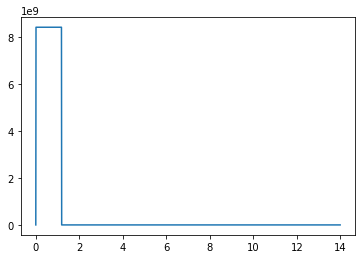

1.188888888888889 1.4444444444444444


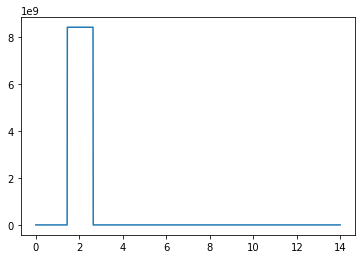

1.188888888888889 2.888888888888889


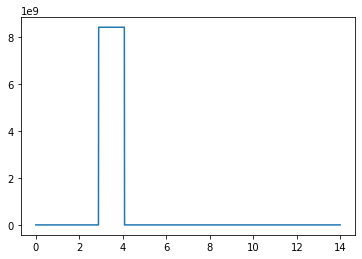

1.188888888888889 4.333333333333333


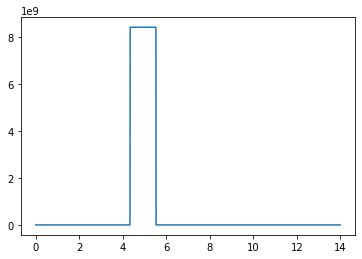

1.188888888888889 5.777777777777778


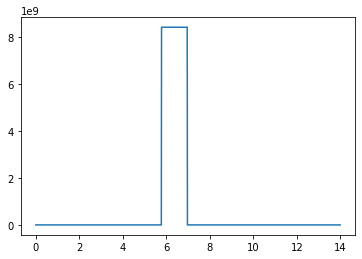

1.188888888888889 7.222222222222222


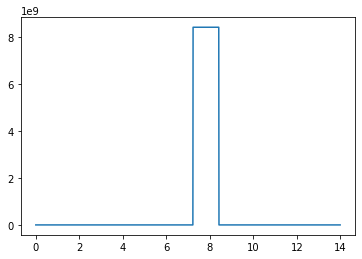

1.188888888888889 8.666666666666666


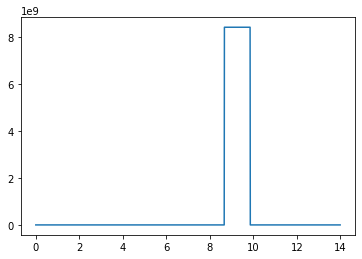

1.188888888888889 10.11111111111111


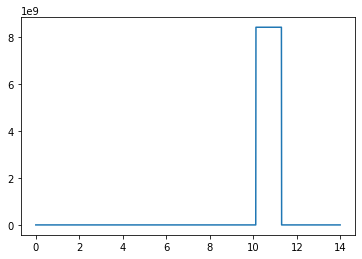

1.188888888888889 11.555555555555555


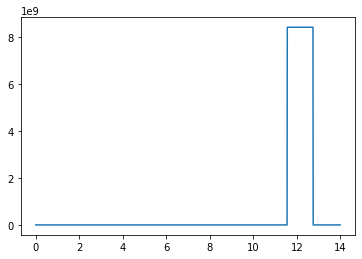

1.188888888888889 13.0


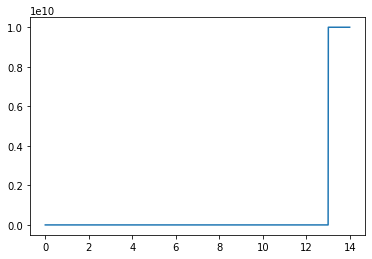

1.7333333333333336 0.0


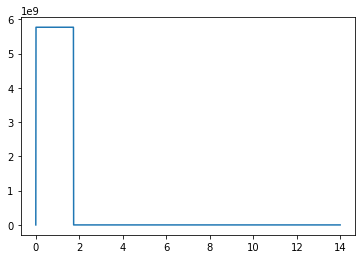

1.7333333333333336 1.4444444444444444


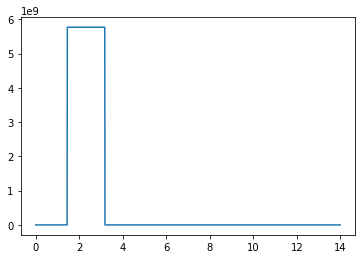

1.7333333333333336 2.888888888888889


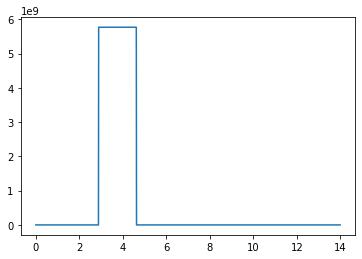

1.7333333333333336 4.333333333333333


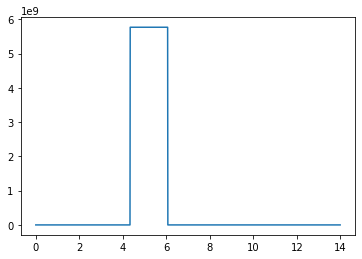

1.7333333333333336 5.777777777777778


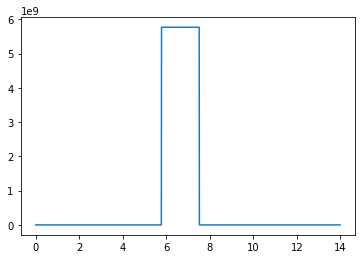

1.7333333333333336 7.222222222222222


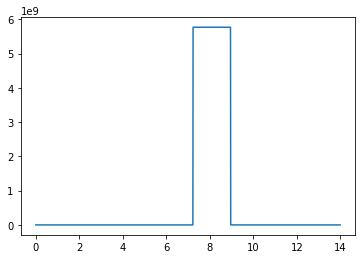

1.7333333333333336 8.666666666666666


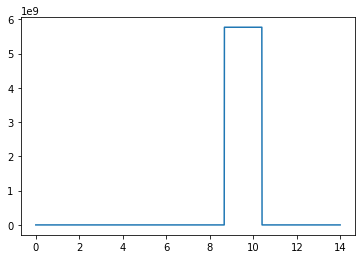

1.7333333333333336 10.11111111111111


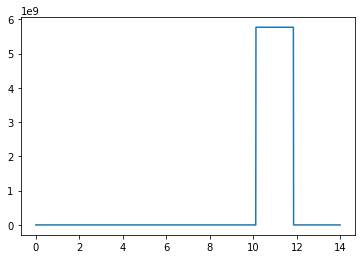

1.7333333333333336 11.555555555555555


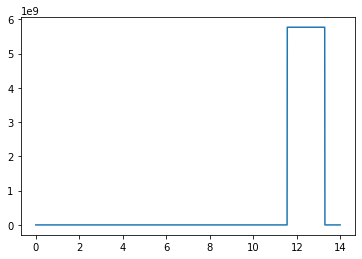

1.7333333333333336 13.0


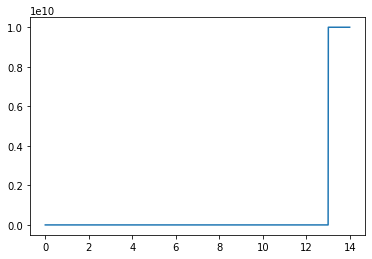

2.277777777777778 0.0


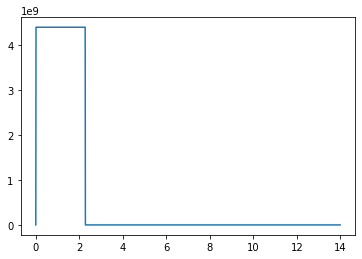

2.277777777777778 1.4444444444444444


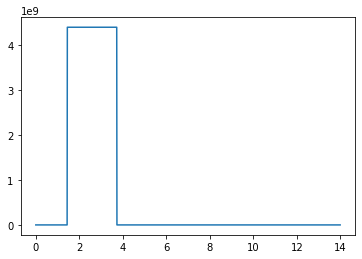

2.277777777777778 2.888888888888889


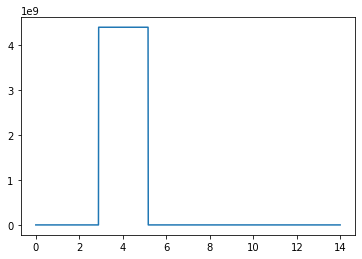

2.277777777777778 4.333333333333333


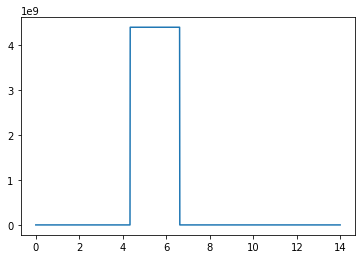

2.277777777777778 5.777777777777778


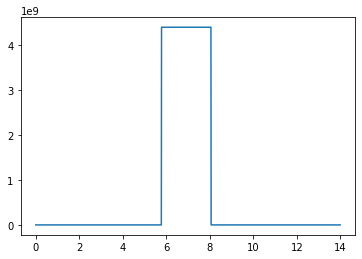

2.277777777777778 7.222222222222222


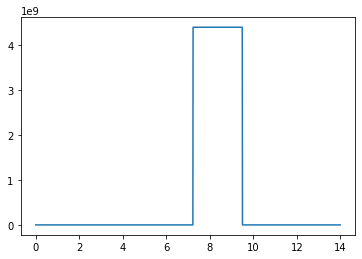

2.277777777777778 8.666666666666666


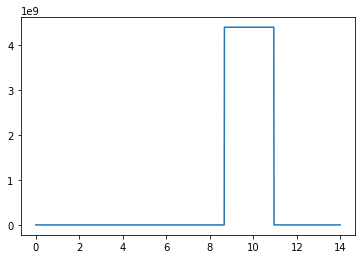

2.277777777777778 10.11111111111111


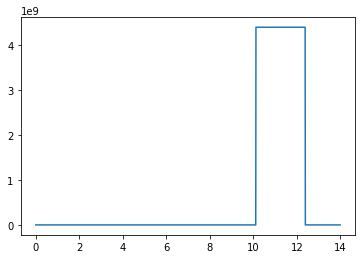

2.277777777777778 11.555555555555555


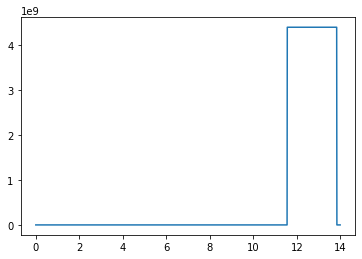

2.277777777777778 13.0


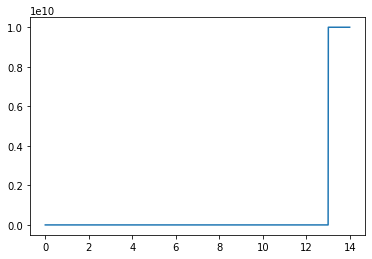

2.8222222222222224 0.0


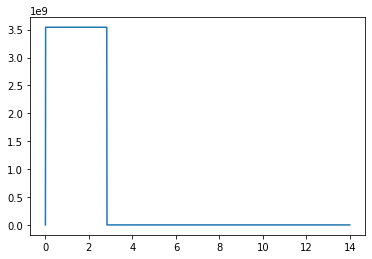

2.8222222222222224 1.4444444444444444


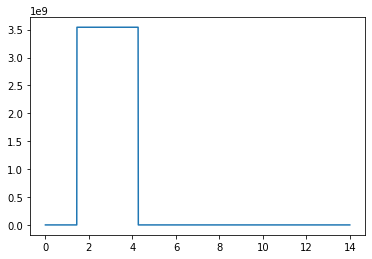

2.8222222222222224 2.888888888888889


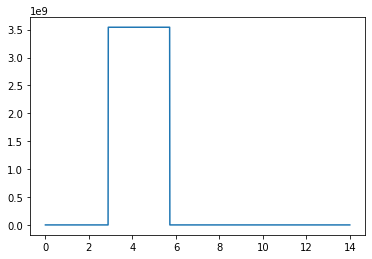

2.8222222222222224 4.333333333333333


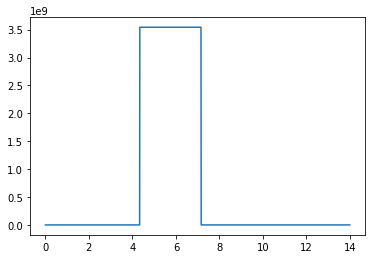

2.8222222222222224 5.777777777777778


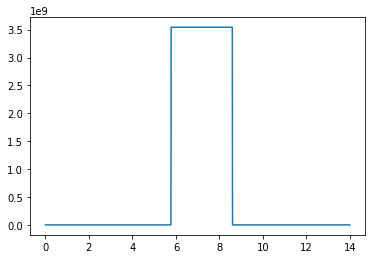

2.8222222222222224 7.222222222222222


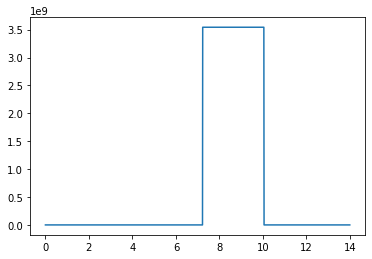

2.8222222222222224 8.666666666666666


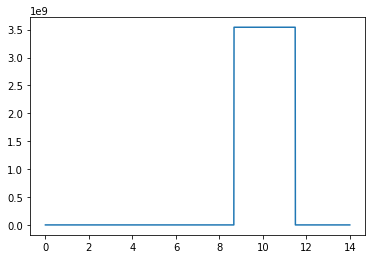

2.8222222222222224 10.11111111111111


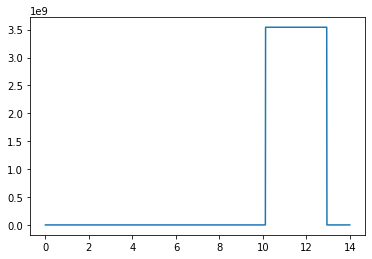

2.8222222222222224 11.555555555555555


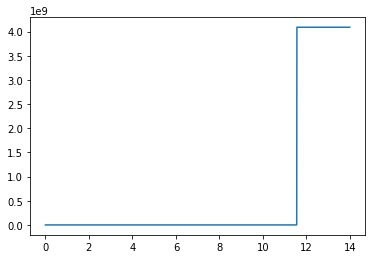

2.8222222222222224 13.0


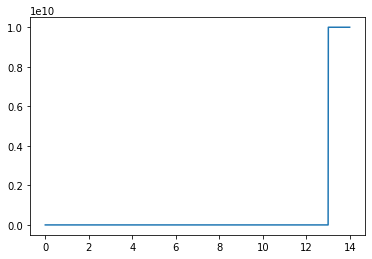

3.366666666666667 0.0


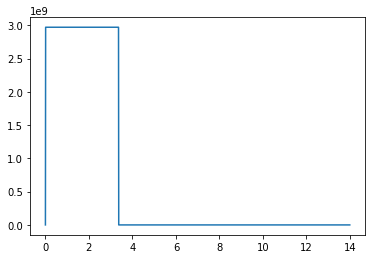

3.366666666666667 1.4444444444444444


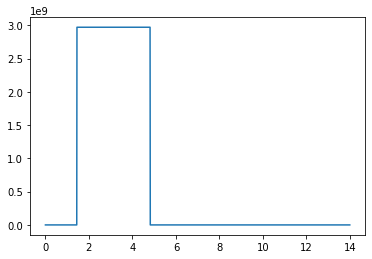

3.366666666666667 2.888888888888889


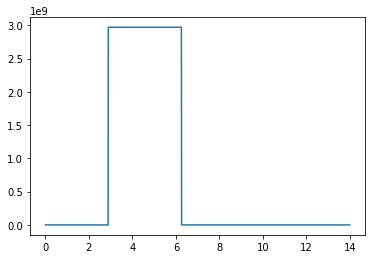

3.366666666666667 4.333333333333333


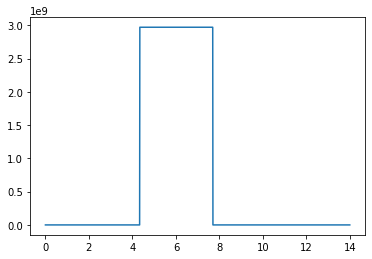

3.366666666666667 5.777777777777778


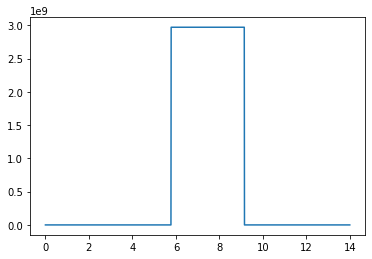

3.366666666666667 7.222222222222222


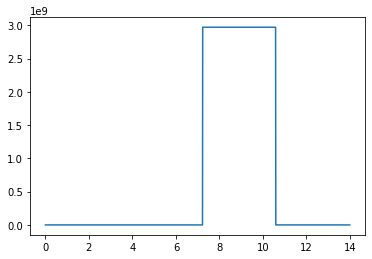

3.366666666666667 8.666666666666666


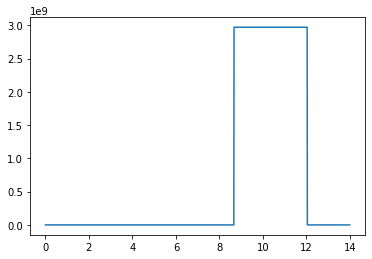

3.366666666666667 10.11111111111111


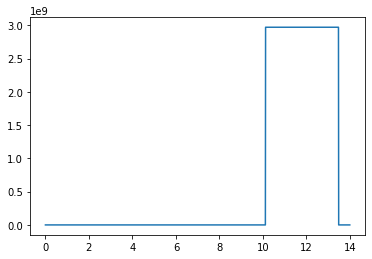

3.366666666666667 11.555555555555555


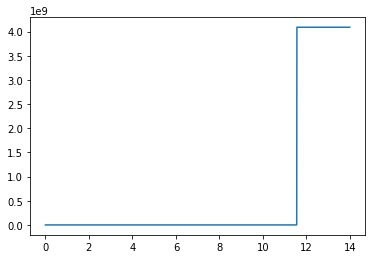

3.366666666666667 13.0


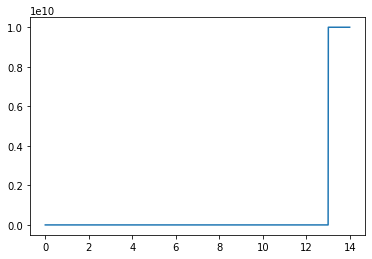

3.911111111111112 0.0


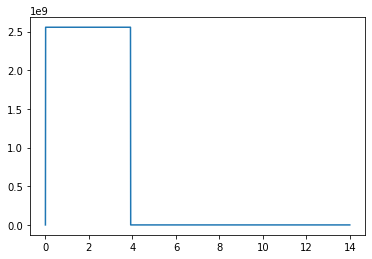

3.911111111111112 1.4444444444444444


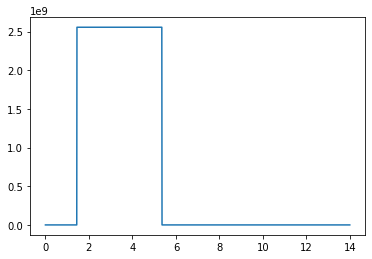

3.911111111111112 2.888888888888889


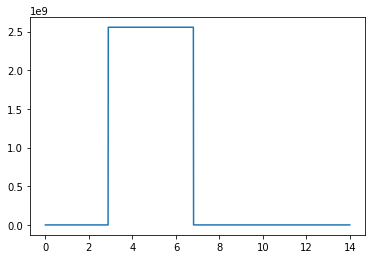

3.911111111111112 4.333333333333333


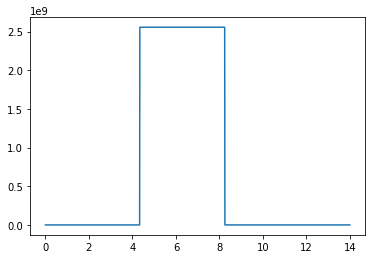

3.911111111111112 5.777777777777778


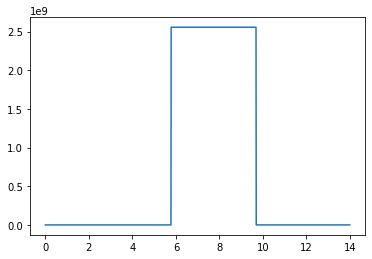

3.911111111111112 7.222222222222222


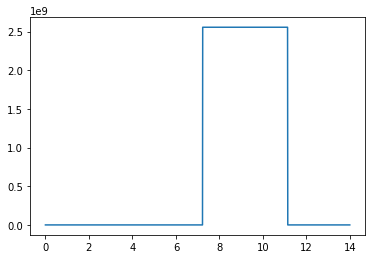

3.911111111111112 8.666666666666666


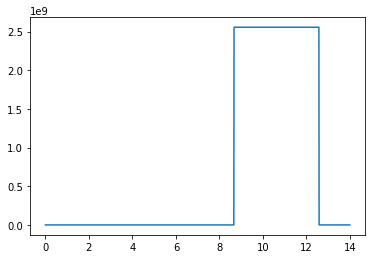

3.911111111111112 10.11111111111111


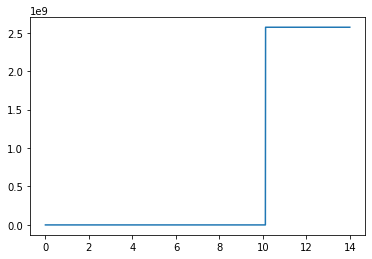

3.911111111111112 11.555555555555555


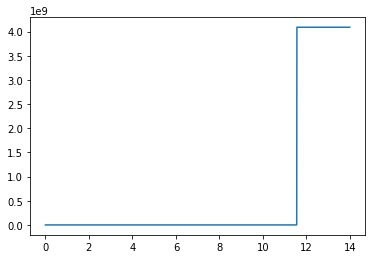

3.911111111111112 13.0


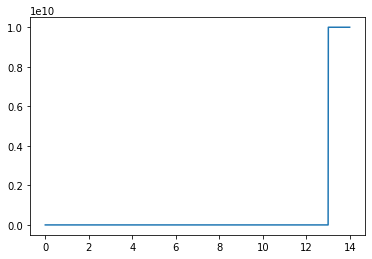

4.455555555555556 0.0


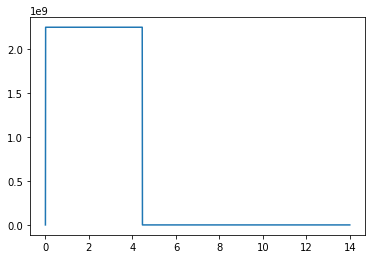

4.455555555555556 1.4444444444444444


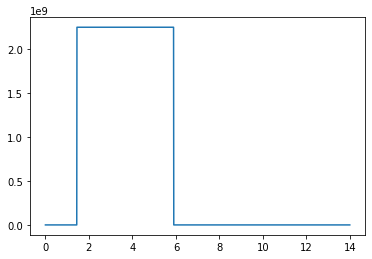

4.455555555555556 2.888888888888889


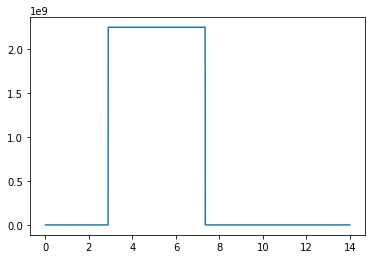

4.455555555555556 4.333333333333333


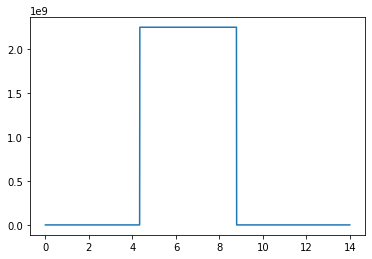

4.455555555555556 5.777777777777778


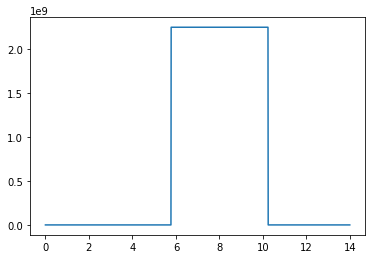

4.455555555555556 7.222222222222222


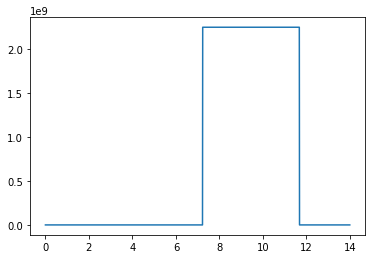

4.455555555555556 8.666666666666666


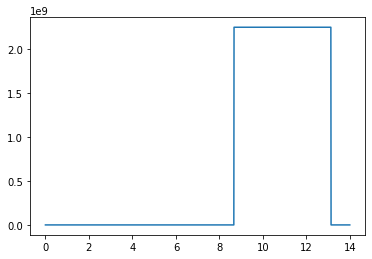

4.455555555555556 10.11111111111111


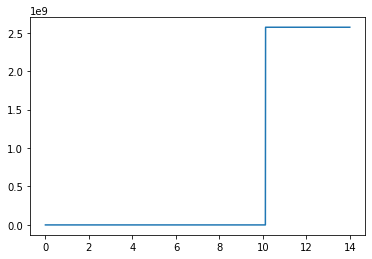

4.455555555555556 11.555555555555555


KeyboardInterrupt: 

In [2]:
def escalon_delta(t,ti,deltat):
    return (t>ti) & (t<ti+deltat)

def delta(t, deltat,ti,mgal):
    i=integrate.quad(lambda t: 1*escalon_delta(t,ti,deltat),0,14)
    A=mgal/(i[0]+1e-12)
    return A*escalon_delta(t,ti,deltat) #units are Msun/Gyr

for i in np.linspace(0.1,5,10):
    for j in np.linspace(0,13,10):
        print(i,j)
        plt.plot(np.arange(0,14,0.01),delta(np.arange(0,14,0.01),i,j,10**10))
        plt.show()

We generate the input training

In [5]:
"""def escalon(t,ti):
    return t>ti

def sfr_linear_exp(t,tau,ti,mgal):
    i=integrate.quad(lambda t:(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti),0,14)
    A=mgal/i[0]
    return A*(t-ti)*np.e**(-(t-ti)/tau)*escalon(t,ti) #units are Msun/Gyr"""

def generate_weights_from_SFHs(SFR,mgal=10**10,deltat=np.linspace(0.1,5,10),ti=np.linspace(0,13,10),tmin=0,tmax=14,step=0.01,percen=True):
    curves=[]
    t=np.arange(tmin,tmax+step,step) 
    for i in deltat:
      for j in ti:
        curve=SFR(t,i,j,mgal)
        curves.append(curve)

    ms=[]
    #non accumulative mass curves, we save it cause we will use it later
    for index,curve in enumerate(curves):        
        sfr_0=curve
        m=[]
        for i,tx in enumerate(t):   
             m_t=sfr_0[i]*step #this gives directly the mass curve (non accumulative)
             m.append(m_t)
        ms.append(m/np.sum(m))

    if percen:
        #compute percentiles
        percentiles=[]
        for i,curve in enumerate(curves):
             mcurve=ms[i]
             m=[]
             percent=[]
             for j in range(len(mcurve)):
                m.append(np.sum(mcurve[:j+1]))
             for k in range(1,10):
                ind=np.argmin(abs(np.array(m)-k/10))
                percent.append(t[ind])
             percentiles.append(percent)  
        return t,ms,percentiles
    else:
        return t,ms

def get_tbins(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))     
    lib_n=np.array(sorted(lib_n))
    return lib_n

def get_data(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))
        
    lib_n=np.array(lib_n)
    data=[]
    
    for j in range(len(lib_n)):
        globals() ['hdul'+str(j)]=fits.open(dir_name+'/'+strs_1+lib[j]+strs_2)
        data.append(np.array(globals()['hdul'+str(j)][0].data))

    hdr=hdul0[0].header
    wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']
    
    ind_sorted=np.argsort(lib_n)
    data=np.array(data,ndmin=2)
    data=data[ind_sorted,:]
    lib_n=lib_n[ind_sorted]
    return wave,data

def interpolate(tbins,t,data):
    data_extended=np.zeros((len(t),len(data[0,:])))
    for i in range(4300):
        x=np.interp(t,tbins,data[:,i])
        data_extended[:,i]=x
    return data_extended

def create_spectrum(t,m,wave,data): #only for a galaxy at a time
    spectrum=[]
    for i in range(len(t)):  #we append older first
         spectrum.append(m[i]*data[-i]) #multiply by the weights
    #data is not normalized, we do not normalize the flux
    spectrum=np.array(spectrum)
    sed=np.sum(spectrum,axis=0) #we add the terms of the linear combination
    return wave,sed

def generate_all_spectrums(t,ms,wave,data_extended):
    seds=[]
    for i,m in enumerate(ms[:]):
        wave,sed=create_spectrum(t,m,wave,data_extended)
        seds.append(sed)
    return wave,seds

def plot_sed_sfh(ms,t,wave,seds,n_int):
    for i,sed in enumerate(seds[::n_int]):
        plt.plot(wave,sed,alpha=0.7)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.title('Artificial spectrum')    
    plt.show()
    t_back=t[::-1]
    for i,m in enumerate(ms[::n_int]):
       plt.plot(t_back,m,'-')

    plt.xlim(14,0)
    plt.xlabel('Lookback time [Gyr]')
    plt.title('Mstar norm non acummulative')
    plt.show()

Generating data...
Step 1/4


/var/folders/26/90klcxjd1_x9q0l8mz3tx1g00000gn/T/ipykernel_49753/3538718787.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i=integrate.quad(lambda t: 1*escalon_delta(t,ti,deltat),0,14)


Step 2/4
Step 3/4
Step 4/4


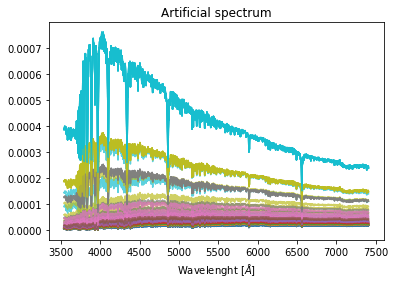

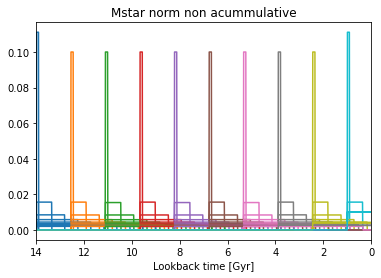

In [6]:
#generate data:
print('Generating data...')
#generate parametrizations (not a lot, just to train)
print('Step 1/4')
#tau from 0.3 to 5 
t,ms,percentiles=generate_weights_from_SFHs(SFR=delta,mgal=10**10,deltat=np.linspace(0.1,5,10),ti=np.linspace(0,13,10),tmin=0,tmax=14,step=0.01,percen=True)
#load MILES spectra and interpolate
print('Step 2/4')
wave,data=get_data(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
print('Step 3/4')
data_extended=interpolate(tbins,t,data)
#generate spectra for the parametrized SFHs
print('Step 4/4')
wave,seds=generate_all_spectrums(t,ms,wave,data_extended)
np.save('./saved_input/t_delta.npy',t)
np.save('./saved_input/percentiles_delta.npy',percentiles)
np.save('./saved_input/waves_delta.npy',wave)
np.save('./saved_input/seds_delta.npy',seds) 
np.save('./saved_input/sfh_delta.npy',ms)

plot_sed_sfh(ms,t,wave,seds,1)

In [7]:
t=np.array(t)
percentiles=np.array(percentiles)
wave=np.array(wave)
seds=np.array(seds)
ms=np.array(ms)

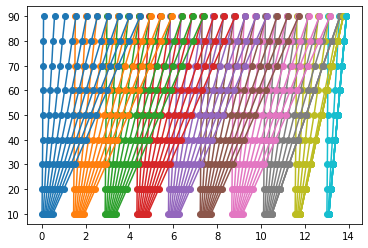

In [8]:
for i in range(len(percentiles[:,0])):
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')

Now that we have our input (spectra + real percentiles) we load a trained model and use it to predict the percentiles of these spectra

In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        self.y=torch.from_numpy(y) #percentiles


    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        y=self.y[index,:]
        return x,y

#create a pytorch dataset

dataset = Dataset(seds[:,:], percentiles[:,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "../../spender/saved_model/generate_latent_2/latent_"+str(n_latent)+"/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=9)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.19it/s]


In [10]:
file="../saved_models/best/my_posterior_1e5_m216.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

In [11]:
posteriors=[]


for i in trange(100):
    posteriors.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)[:,0,:]

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 54.36it/s]


(100, 9)


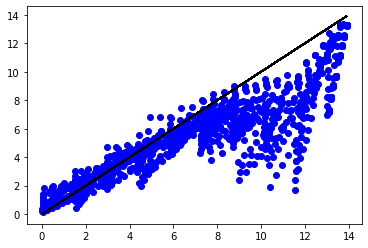

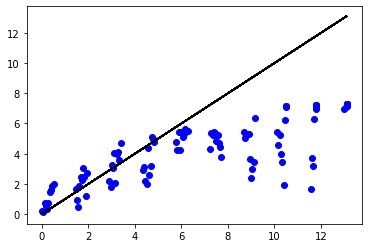

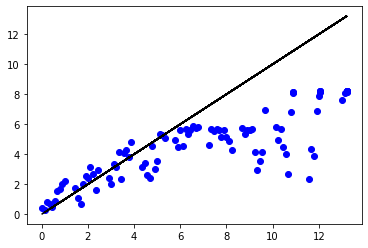

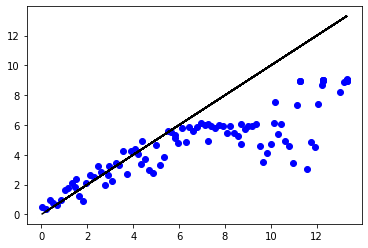

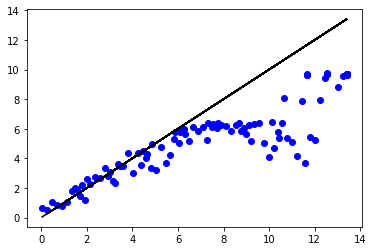

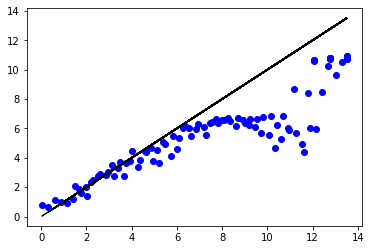

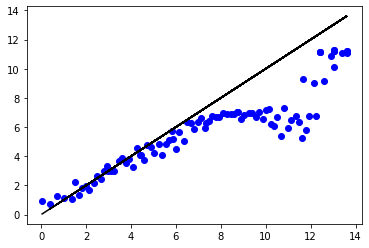

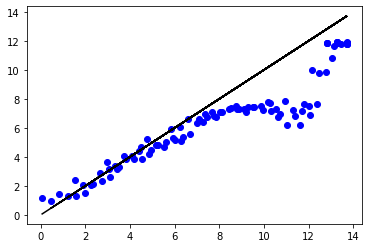

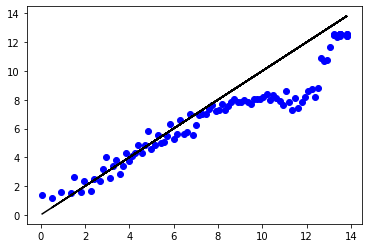

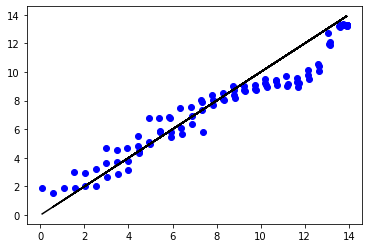

In [12]:
print(np.shape(posteriors))

for i in range(9):
    plt.plot(percentiles[:,i],posteriors[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
plt.show()

for i in range(9):
    plt.plot(percentiles[:,i],posteriors[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
    plt.show()

Right now we try to predict distributions (1000 samples)

In [14]:
posteriors_dist=[]


for i in trange(100):
    posteriors_dist.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)

100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


(100, 1000, 9)
(100, 9)


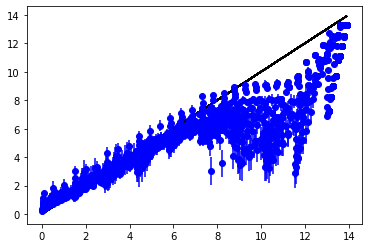

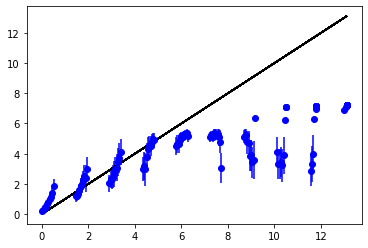

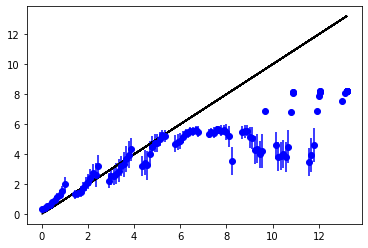

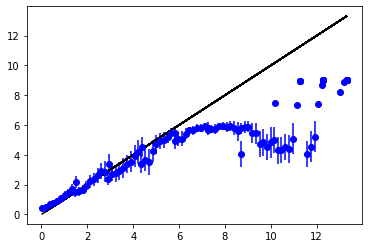

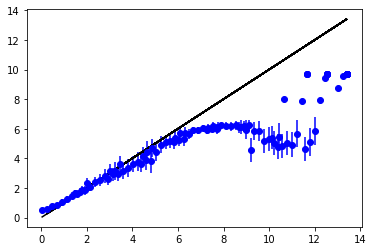

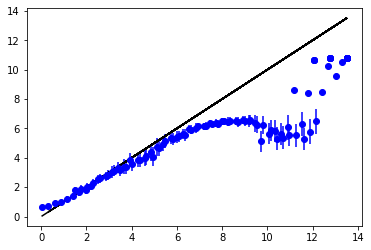

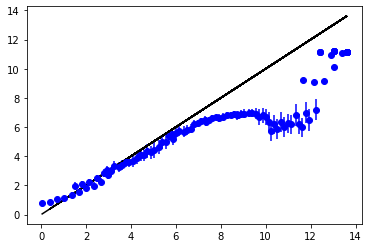

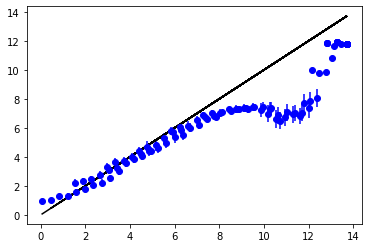

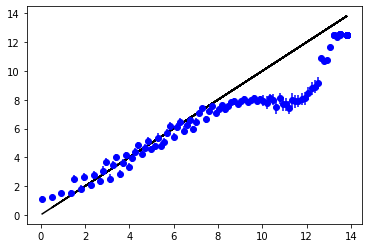

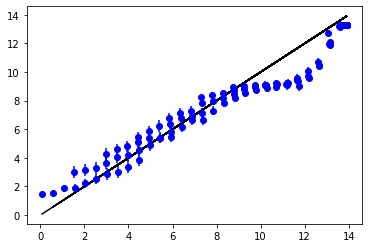

In [16]:
print(np.shape(posteriors_dist))

means=np.mean(posteriors_dist,axis=1)
stds=np.std(posteriors_dist,axis=1)

print(np.shape(means))


for i in range(9):
    plt.errorbar(percentiles[:,i],means[:,i],yerr=stds[:,i],fmt='bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
plt.show()


for i in range(9):
    plt.errorbar(percentiles[:,i],means[:,i],yerr=stds[:,i],fmt='bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
    plt.show()

Let's see if the error is well estimated

In [35]:
import math

def get_coverage_probabilities_nomodel(y_real,y_pred,y_pred_std):
    """
    Compute the coverage probabilities on test dataset
    
    :param y:  The data true values
    :param y_pred: The mean of the predicted distributions
    :param y_pred_std: The standard deviation of the predicted distributions
    :return: (x, y) a tuple of lists corresponding to a list of probability volumes
    and the corresponding percentage of true values in that volume.
    """
    

    errors = np.absolute(y_real - y_pred)
    x, y = [], []
    for sigma_times in np.arange(0, 3, 0.01):
        how_many = np.count_nonzero(errors <= sigma_times * y_pred_std)
        y.append(how_many / y_real.shape[0])
        x.append(math.erf(sigma_times / math.sqrt(2))) #the method erf returns the error function of a number.
    return x, y


def plot_with_median(data_x, data_y,ax, label=None, percentiles=(16, 84), total_bins=20):
    """
    Plot the running media of the data_x, data_y data with requested percentiles.
    :param data_x:
    :param data_y:
    :param label: The label that should be displayed on the legend
    :param percentiles: The percentiles to plot along with the median
    :param total_bins: The number of bins to digitize the data. Increase to increase detail.
    :return:
    """
    bins = np.linspace(data_x.min(), data_x.max(), total_bins)

    delta = bins[1] - bins[0]
    idx = np.digitize(data_x, bins)
    running_median = [np.nanmedian(data_y[idx == k]) for k in range(total_bins)]
    running_prc_low = [np.nanpercentile(data_y[idx == k], percentiles[0])
                       for k in range(total_bins)]
    running_prc_high = [np.nanpercentile(data_y[idx == k], percentiles[1])
                        for k in range(total_bins)]

    if percentiles:
        ax.plot(bins-delta/2, running_median, lw=2, alpha=.8, color='blue', label=label)
        ax.fill_between(bins - delta / 2, running_prc_low, running_median, color='blue', alpha=0.1)
        ax.fill_between(bins - delta / 2, running_prc_high, running_median, color='blue', alpha=0.1)
    else:
        ax.plot(bins - delta / 2, running_median, linestyle='--', lw=2, alpha=.8,  label=label)
        
        
def init_coverage_plot():
    """
    Initialize the coverage plot and add text for marking
    overconfident and conservative regions
    :return:
    """
    f = plt.figure(figsize=(10, 8))
    ax = f.add_subplot()
    ax.set_xlabel('Percentage of probability volume')
    ax.set_ylabel('Percentage of true values in volume')
    ax.set_title('Probability Coverage')

    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.text(0.3, 0.9, '$\it{Conservative}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)

    plt.text(0.7, 0.1, '$\it{Overconfident}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
    return f, ax

/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


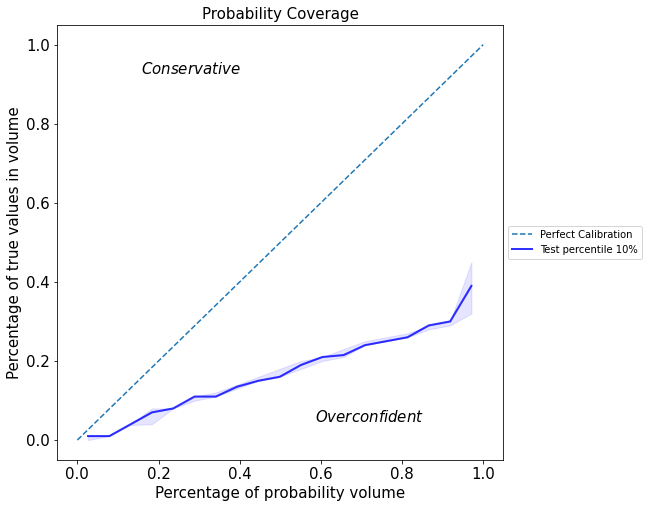

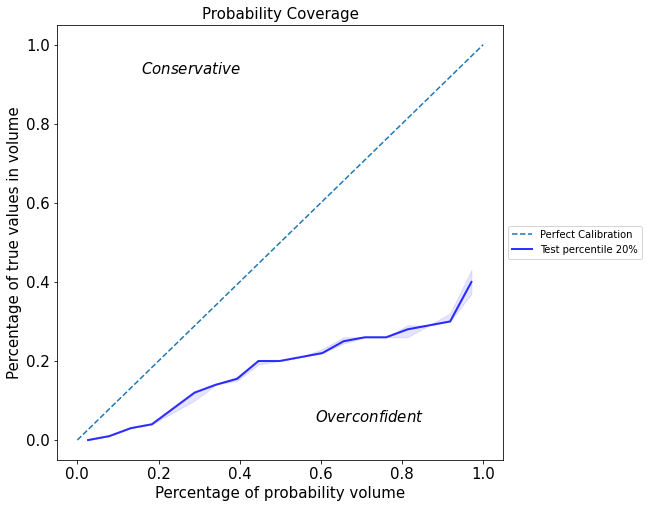

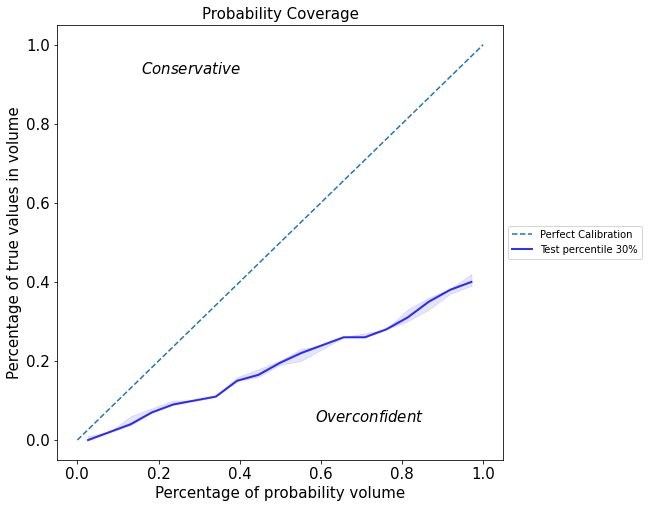

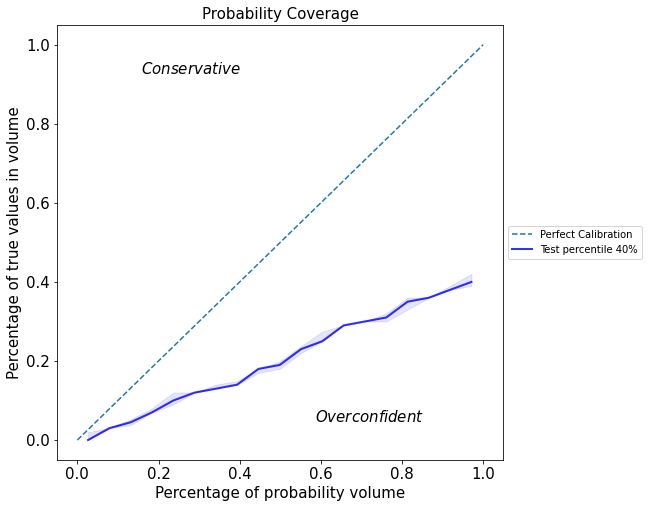

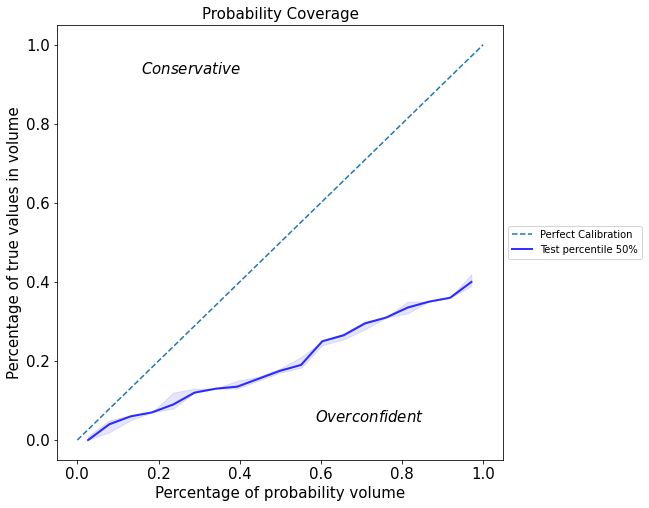

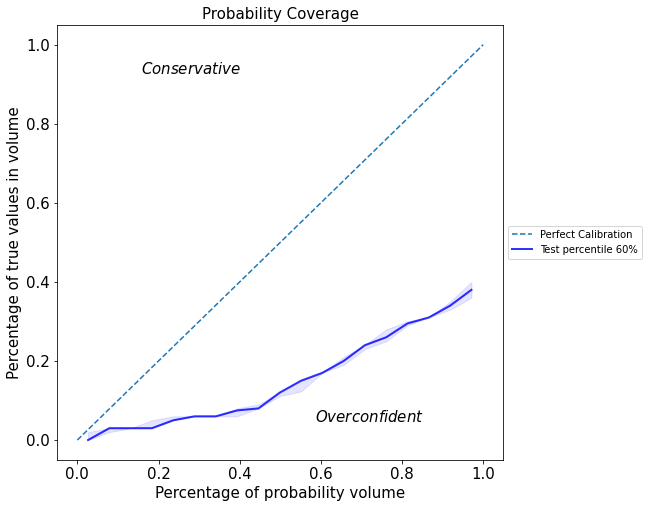

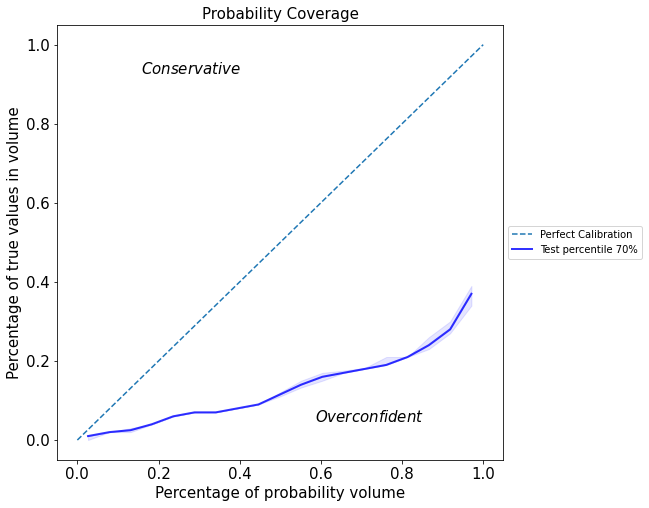

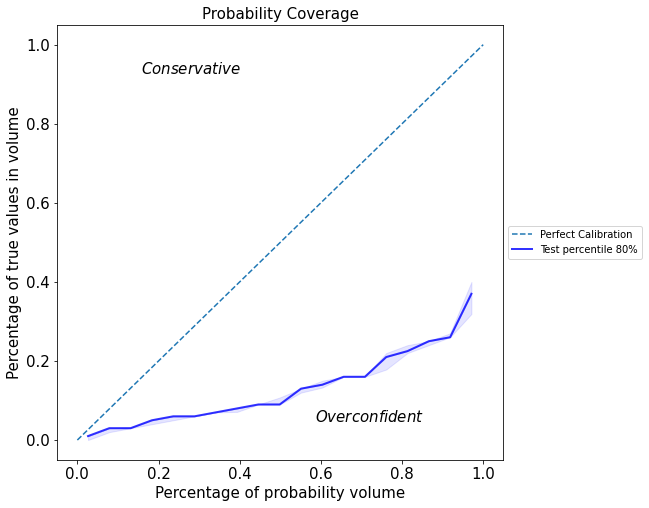

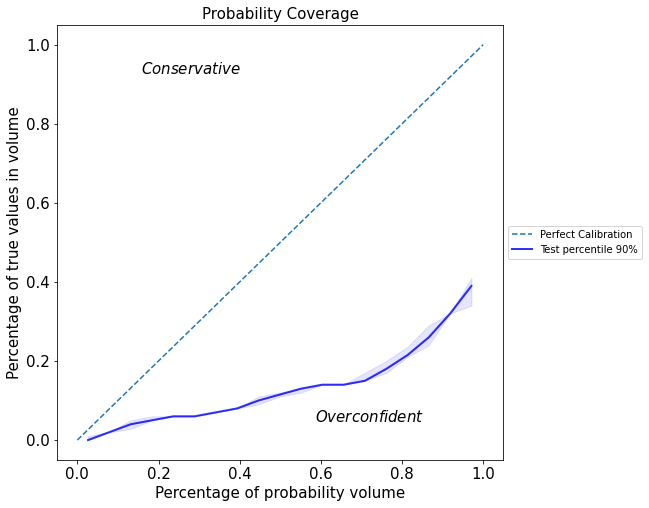

In [36]:
y=np.copy(percentiles)
y_pred=np.copy(means)
y_pred_std=np.copy(stds)


for i in range(9):
    
    data_x,data_y=get_coverage_probabilities_nomodel(np.array(y)[:,i],y_pred[:,i],y_pred_std[:,i])
    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', titlesize=15, labelsize=15)
    f, ax =init_coverage_plot()
    
    if i<9:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Test percentile '+str((i+1)*10)+'%')
    else:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Metallicity')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    #plt.savefig('coverage_'+str(i)+'.jpg')
    plt.show()
    plt.close()

